The whole notebook run on UKB-RAP instance: mem2_ssd1_v2_x8 (75% of 32 GB total RAM and 5 out of 8 cores utilized).

## 1. General data checking and cleaning

In [ ]:
!pip install missingno

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 201.0 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.3 MB/s eta 0:00:00ta 0:00:01


In [ ]:
!pip install openpyxl

### 1.1 Prepare the dataset

In [ ]:
%%bash
dx download "UKB Metabolomics:/agarham/participant_dataset.tsv"

In [ ]:
%%bash
dx download "UKB Metabolomics:qrilc_imputed_metabolomics_v3.csv"

In [ ]:
%%bash
dx download "UKB Metabolomics:/agarham/biomarker_bridge.csv"

In [ ]:
%%bash
dx download "UKB Metabolomics:/agarham/psoriasis_severity1y_icdgpmed.tsv"

In [ ]:
%%bash
dx download "UKB Metabolomics:/agarham/psa_diagnoses_v2.tsv"

In [ ]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import pandas as pd
import numpy as np

df = pd.read_csv('participant_dataset.tsv', sep = '\t')
df.shape

(501966, 463)

For memory and time efficiency, here we create a random subset using only 10% of the real data.
This subset is used for trial purposes, before running with the whole dataset.

In [ ]:
# # Create a random subset of the dataset
# subset = df.sample(frac=0.01, replace=False, random_state=1)
# subset.to_csv('participant_dataset_subset.csv', index=False)

If needed, for running outside of the cloud (in local machine), create a synthetic data representing the real data.

In [ ]:
# from sdv.tabular import GaussianCopula
# import pandas as pd

# Fit the model on real data
# model = GaussianCopula()
# model.fit(subset)

# # Generate synthetic data
# synthetic_data = model.sample()

# synthetic_data.head()

Now, we are slicing the dataset for participants with available metabolomics, and create a dataframe containing the selected covariates only.

In [ ]:
# Load the metabolomics dataset
met_df = pd.read_csv('qrilc_imputed_metabolomics_v3.csv')
met_df.shape

(480840, 328)

In [ ]:
# Import data containing the data fields, metabolite name, abbreviations (to be used as column names), and categories of the metabolites
met_info = pd.read_csv('biomarker_bridge.csv', sep = ';')

# Create a list of metabolite columns to be selected from the dataframe
met_cols = met_info['biomarker_hunt'].to_list()
met_cols.insert(0, 'eid')

# Select and rename the columns
met_df = met_df[met_cols]
met_df.shape

(480840, 250)

In [ ]:
# Slice to metabolomics available dataset only
df = df[df['eid'].isin(met_df['eid'])] # change: df to subset for testing subset only
df.shape

(480840, 463)

In [ ]:
# Create a list of columns to be selected
base_cols = ['eid', # Participant IDs
             '74-0.0', # Fasting time
             '31-0.0', # Sex
             '21001-0.0', # BMI
             '20116-0.0', # Smoking status
             '21003-0.0', # Age at participation
             '54-0.0' # Assessment centre
            ]

# Create a list of column names
base_names = ['eid',
              'fast',
              'sex',
              'bmi',
              'smo',
              'age',
              'cent'
             ]

# Create a dictionary to pair the old column names with the new column names
base_cols_map = dict(zip(base_cols, base_names))

# Select and rename the columns
baseline_df = df[base_cols].rename(columns=base_cols_map)
baseline_df.shape

(480840, 7)

### 1.2. Clean up covariates

Ethnicity was recorded during the initial visit and repeats. Some participants who did not answer during the initial visit answered during the repeats. Because ethnicity doesn't change, we can fill the missing data in the initial visit with the repeats. Here, we code caucasians into 1, and other ethnicities into 0 (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=1001). We do not need to recode those answering do not know (-1) or prefer not to answer (-3) as we only care about the caucasian ethnicity to select.

In [ ]:
# Create function to perform the recoding
def recode(df, columns, old_codes):
    # Condition: Check if any of the specified columns contain the old codes
    condition = df[columns].isin(old_codes).any(axis=1)
    # Use np.select to assign 1 if condition is True, else 0
    recoded = np.select([condition], [1], default= 0)

    return recoded


#Recode ethnicity
# Create lists of the columns to be recoded
eth_cols = ['21000-0.0', '21000-1.0', '21000-2.0']

# Recode and add the recoded columns into the baseline data frame
baseline_df['eth'] = recode(df, eth_cols, [1, 1001, 1002, 1003]) # Codes for Caucasian: 1, 1001, 1002, or 1003

# Check number of ethnicity
print(f"Caucasian ethnicity: {(baseline_df['eth'] == 1).sum()}")

Caucasian ethnicity: 453428


Self reported medication is separated for female (data field 6153) and male (data field 6177).
Touchscreen question "Do you regularly take any of the following medications? (you can select more than one answer)".
The answers were coded as 1, if the participant used cholesterol lowering medication (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100625).
Here we create a new variable 'meds' combining both data fields. Participants who answered 1 in any of these data fields are coded as 1, others as 0. For those answering do not know (-1) or prefer not to answer (-3) are coded as missing (NaN) and will be imputed later.

In [ ]:
# Define medication columns
med_cols = ['6153-0.0', '6177-0.0']

# Identify rows with -1 or -3
def contains_invalid(val):
    if isinstance(val, str):
        return any(x in val.split('|') for x in ['-1', '-3'])
    return val in [-1, -3]

# Create a mask
invalid_mask = df[med_cols].applymap(contains_invalid).any(axis=1)

# Recode presence of '1' to indicate lipid medication use
def contains_1(val):
    if isinstance(val, str):
        return '1' in val.split('|')
    return False

for col in med_cols:
    df[col] = df[col].apply(contains_1).astype(int)

# Recode and assign
baseline_df['meds'] = recode(df, med_cols, [1])

# Apply NaN to 'meds' where original values are -1 or -3
baseline_df.loc[invalid_mask, 'meds'] = np.nan

# Check results
print(f"NaNs in meds: {baseline_df['meds'].isna().sum()}")
print(f"On lipid medication: {(baseline_df['meds'] == 1).sum()}")

NaNs in meds: 3639
On lipid medication: 83101


Smoking questionnaire allows participants to choose "prefer not to answer" which was coded as -3 (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=90). We will recode these values into NaN.

In [ ]:
# Check number of -1 and -3 codes before replacement
print('before replacement:')
print(baseline_df['smo'].value_counts())

# Replace -1 and -3 codes in smo to NaN
baseline_df['smo'] = baseline_df['smo'].replace([-1, -3], np.nan)

# Correct the data types
baseline_df['smo'] = baseline_df['smo'].astype('Int64')
print(baseline_df['smo'].dtypes)

# Check the result
print('after replacement:')
print(baseline_df['smo'].value_counts())

before replacement:
smo
 0.0    261990
 1.0    166022
 2.0     50387
-3.0      1939
Name: count, dtype: int64
Int64
after replacement:
smo
0    261990
1    166022
2     50387
Name: count, dtype: Int64


Next, we will prepare diets related variables for sensitivity analysis as suggested by the reviewer.

In [ ]:
%%bash
dx download "exported_intake_191225.tsv"

In [ ]:
# Load the dataset
diets = pd.read_csv("exported_intake_191225.tsv", sep = "\t")

# Rename columns
col_names = ['eid',
             'alcohol', #1558
             'cook_veg', #1289
             'raw_veg', #1299
             'fresh_fru', #1309
             'dry_fru', #1319
             'oily_fish', #1329
             'upf', #1349
             'beef', #1369
             'lamb', #1379
             'pork', #1389
             'suppl' #6179
            ]

diets.columns = col_names

# Recode all -1 and -3 to NaN as these represents "do not know" and "prefer not to answer"
diets = diets.replace([-1, -3], np.nan)

# Simplifying the categories into never/rarely and regularly
coding_type1 = ['oily_fish', 'upf', 'beef', 'lamb', 'pork']

diets[coding_type1] = diets[coding_type1].replace([0, 1], 0) # recode 0 (never) and 1 (less than 1 time a week) to 0 (never or rarely)
diets[coding_type1] = diets[coding_type1].replace([2, 3, 4, 5], 1) # recode 2 (1 time a week), 3 (2-4 times a week), 4 (5-6 times a week), and 5 (> 1 time daily) to 1 (regularly)

# Code fish oil intake into 1 if 1 present, other 0
mask_nan = diets['suppl'].isna()

diets['tran'] = (diets['suppl'].astype(str)
                 .str.contains(r'(^|\|)1(\||$)')
                 .astype(int)
                )

diets.loc[mask_nan, 'tran'] = np.nan

# Grouping of oily fish and fish oil supplement
fish_tran = ['oily_fish', 'tran']

diets['fish_tran'] = (diets[fish_tran].eq(1).any(axis=1).astype(int))
diets.loc[diets[fish_tran].isna().all(axis=1), 'fish_tran'] = np.nan

# Grouping beef, lamb/mutton, and pork into red meat
red_meat = ['beef', 'lamb', 'pork']
# if regularly (1, at least once a week) consume any of beef, lamb/mutton, or pork then fill 1, else 0
diets['red_meat'] = (diets[red_meat].eq(1).any(axis=1).astype(int))
diets.loc[diets[red_meat].isna().all(axis=1), 'red_meat'] = np.nan

# Grouping vegetables and fruit
veg_fru = ['cook_veg', 'raw_veg', 'fresh_fru', 'dry_fru']
# if daily (at least once a day) then fill 1, else 0 (coded by ukb as -10, less than 1 portion a day)
diets['veg_fru'] = (diets[veg_fru].ge(1).any(axis=1).astype(int))
diets.loc[diets[veg_fru].isna().all(axis=1), 'veg_fru'] = np.nan

# Merge diets related variables to the main dataframe
baseline_df = baseline_df.merge(diets[['eid', 'red_meat', 'veg_fru', 'fish_tran', 'upf']], how = 'left', on = 'eid')

# Check
print(baseline_df['fish_tran'].value_counts())
print(baseline_df['red_meat'].value_counts())
print(baseline_df['veg_fru'].value_counts())
print(baseline_df['upf'].value_counts())

fish_tran
1.0    321201
0.0    159108
Name: count, dtype: int64
red_meat
1.0    266727
0.0    212718
Name: count, dtype: int64
veg_fru
1.0    473697
0.0      5916
Name: count, dtype: int64
upf
1.0    288668
0.0    190434
Name: count, dtype: int64


### 1.3. Imputation of covariates

In [ ]:
# Prepare the dataset
to_impute = baseline_df.merge(met_df, on = 'eid')
eid = to_impute['eid']

# Drop EID (not needed / do not contain any information for the imputation)
to_impute = to_impute.drop(columns=['eid'])

# Check missingness
print('proportion of missing values (%):')
print(to_impute[['sex', 'bmi', 'smo', 'age', 'cent', 'eth', 'meds', 'red_meat', 'veg_fru', 'fish_tran', 'upf']].isnull().sum() * 100 / len(to_impute))

proportion of missing values (%):
sex          0.000000
bmi          0.403045
smo          0.507653
age          0.000000
cent         0.000000
eth          0.000000
meds         0.756801
red_meat     0.290117
veg_fru      0.255178
fish_tran    0.110432
upf          0.361451
dtype: float64


<Axes: >

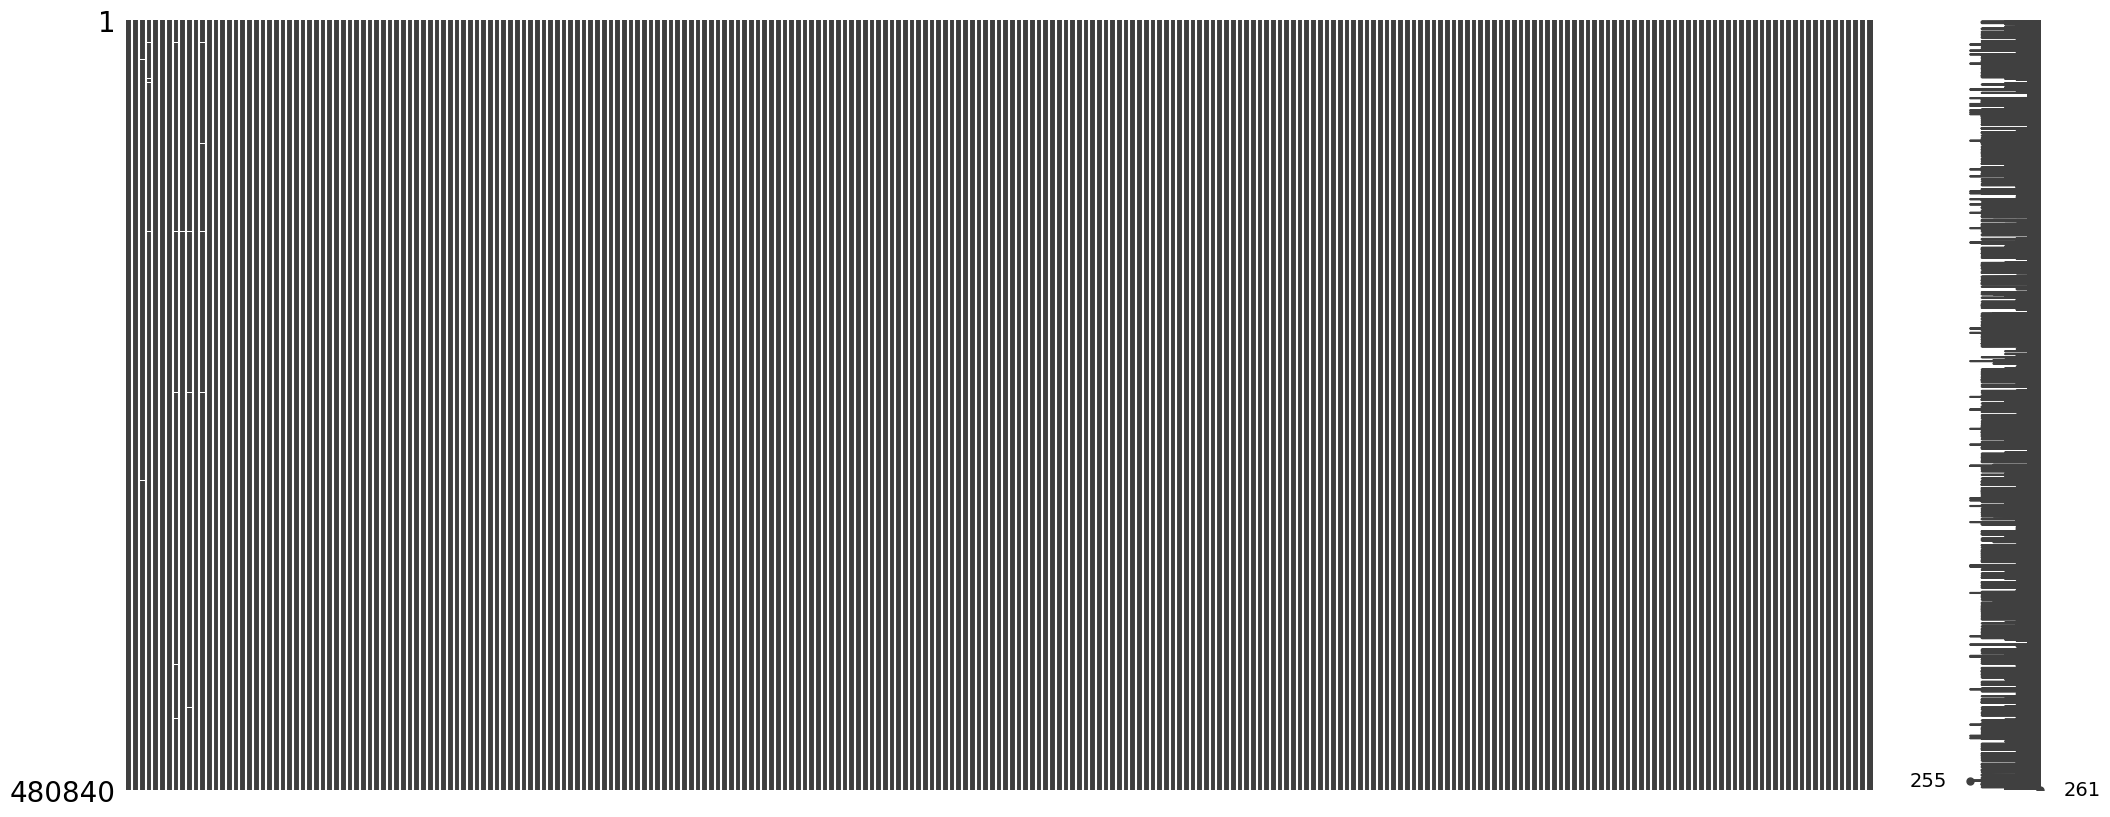

In [ ]:
# Check the missingness visually
import missingno as msno
msno.matrix(to_impute)

In [ ]:
# Impute the dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor

imputer = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features='sqrt', max_depth=10, random_state=0),
    max_iter=5,
    initial_strategy='most_frequent',
    n_nearest_features=20,
    skip_complete=True,
    random_state = 0
)

imputed = imputer.fit_transform(to_impute)
imputed_df = pd.DataFrame(imputed, columns = to_impute.columns)

<Axes: >

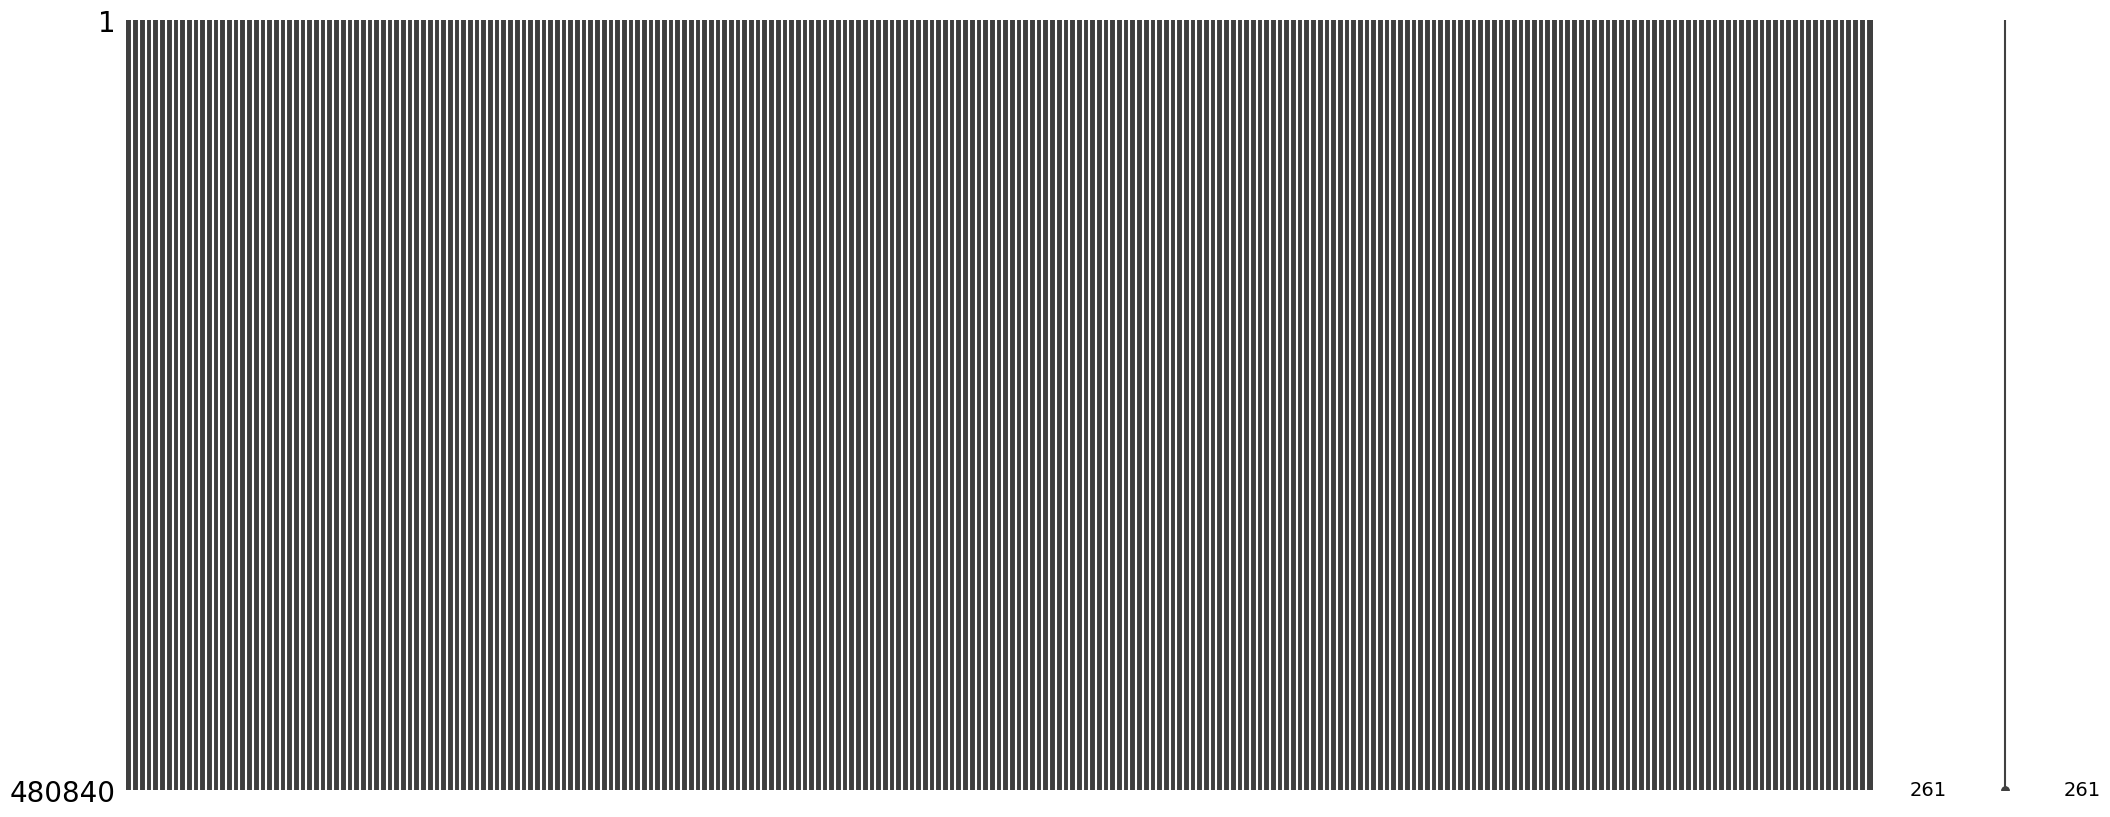

In [ ]:
# Check the imputation result visually
msno.matrix(imputed_df)

In [ ]:
# Check the imputation result
print('proportion of missing values (%):')
print(imputed_df[['bmi', 'smo', 'meds', 'red_meat', 'veg_fru', 'fish_tran', 'upf']].isnull().sum() * 100 / len(imputed_df))

proportion of missing values (%):
bmi          0.0
smo          0.0
meds         0.0
red_meat     0.0
veg_fru      0.0
fish_tran    0.0
upf          0.0
dtype: float64


In [ ]:
# Transfer back the eid
imputed_df['eid'] = eid

# Changing data types (the imputation changes the datatype into float)
imputed_df['smo'] = imputed_df['smo'].round().astype('int64').astype('category')
imputed_df['meds'] = imputed_df['meds'].round().astype('int64')
imputed_df['red_meat'] = imputed_df['red_meat'].round().astype('int64')
imputed_df['veg_fru'] = imputed_df['veg_fru'].round().astype('int64')
imputed_df['fish_tran'] = imputed_df['fish_tran'].round().astype('int64')
imputed_df['upf'] = imputed_df['upf'].round().astype('int64')

# Save the output
imputed_df.to_csv('final_imputed_dataset_v3.csv', index = False)

<Axes: >

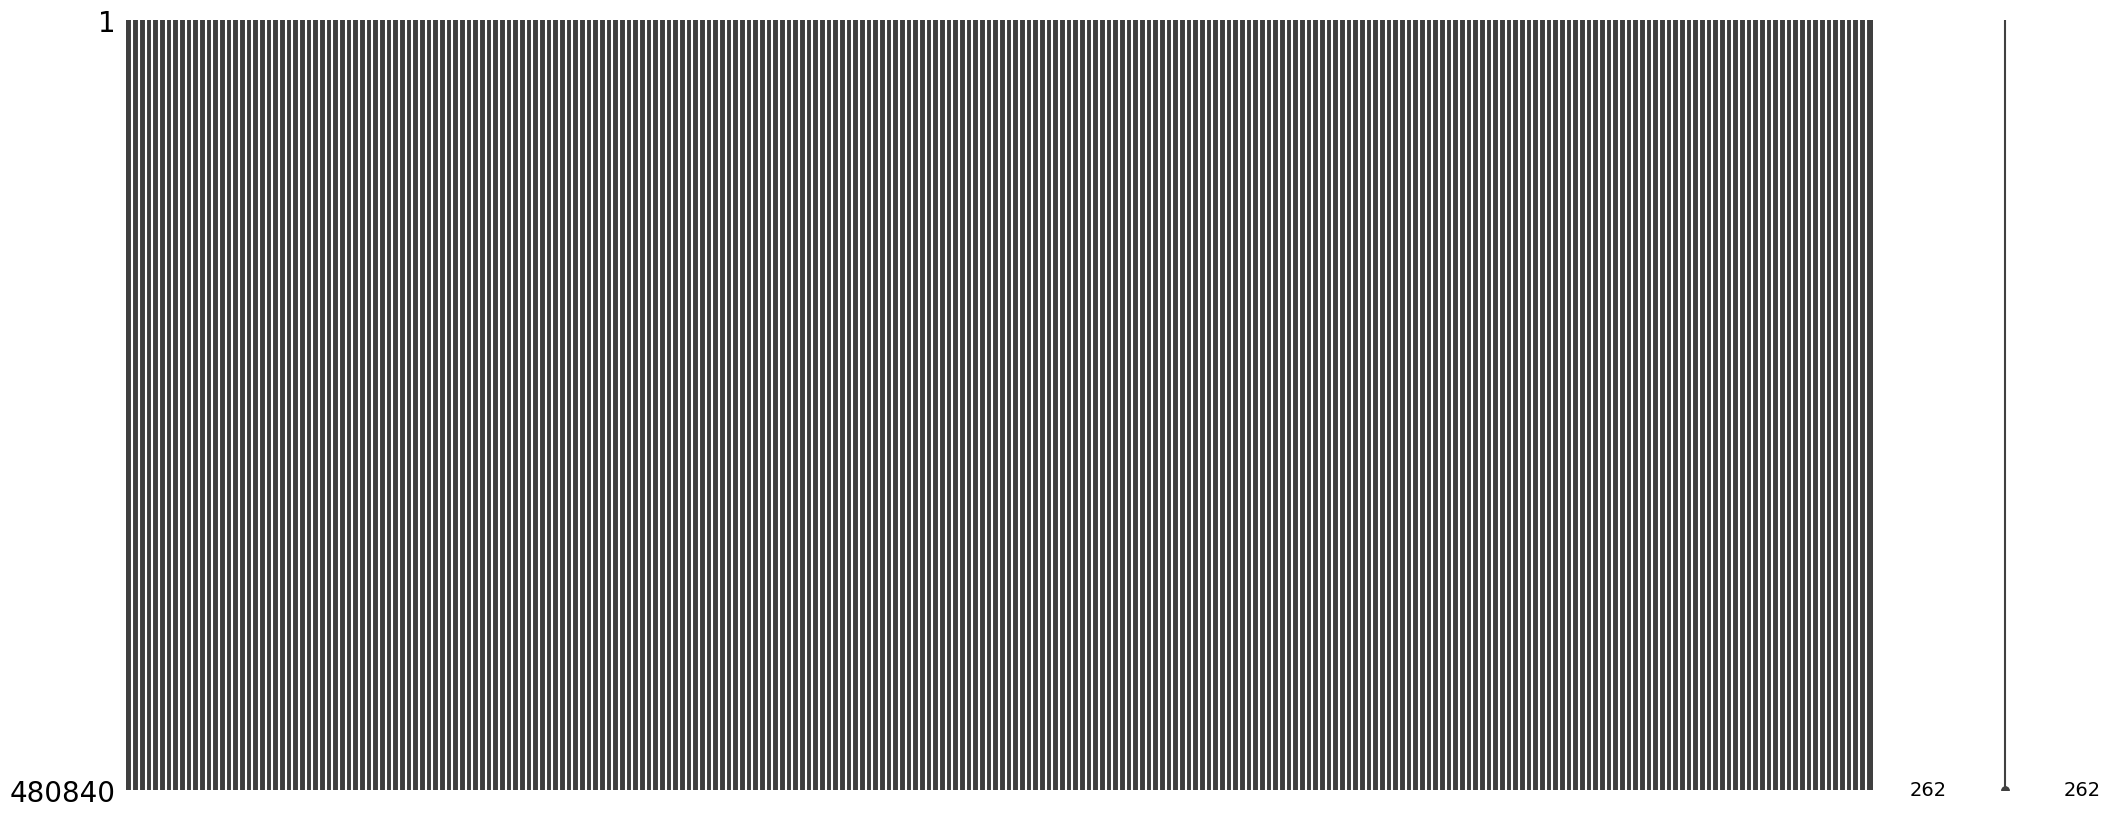

In [ ]:
# Check the missingness visually
msno.matrix(imputed_df)

In [ ]:
%%bash
dx upload "final_imputed_dataset_v3.csv"

ID                                file-J5gjx4QJZ8jzfY2Pp4zB0b35
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              final_imputed_dataset_v3.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 20 14:17:54 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Tue Jan 20 14:17:59 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [ ]:
# Define function to evaluate the imputation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def compare_imputed_vs_original(original_df, imputed_df, columns, var_type='continuous', pdf_filename='comparison_plots.pdf'):
    with PdfPages(pdf_filename) as pdf:
        for col in columns:
            plt.figure(figsize=(6, 4))

            if var_type == 'continuous':
                sns.kdeplot(original_df[col].dropna(), label='Original (non-missing)', fill=True)
                sns.kdeplot(imputed_df[col], label='Imputed', fill=True)
                plt.title(f'Distribution for {col}')

            elif var_type == 'categorical':
                orig_counts = original_df[col].dropna().value_counts(normalize=True)
                imp_counts = imputed_df[col].value_counts(normalize=True)
                compare_df = pd.DataFrame({'Original': orig_counts, 'Imputed': imp_counts}).fillna(0)
                compare_df.plot(kind='bar', ax=plt.gca())
                plt.title(f'Category distribution for {col}')
                plt.ylabel('Proportion')

            plt.legend()
            plt.tight_layout()
            pdf.savefig()
            plt.close()

# Perform imputation visual evaluation
compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['bmi'],
                            var_type='continuous',
                            pdf_filename='imputation - bmi.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['smo'],
                            var_type='categorical',
                            pdf_filename='imputation - smo.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['meds'],
                            var_type='categorical',
                            pdf_filename='imputation - meds.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['red_meat'],
                            var_type='categorical',
                            pdf_filename='imputation - red_meat.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['veg_fru'],
                            var_type='categorical',
                            pdf_filename='imputation - veg_fru.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['fish_tran'],
                            var_type='categorical',
                            pdf_filename='imputation - fish_tran.pdf'
                           )

compare_imputed_vs_original(original_df=to_impute,
                            imputed_df=imputed_df,
                            columns=['upf'],
                            var_type='categorical',
                            pdf_filename='imputation - upf.pdf'
                           )

In [ ]:
%%bash
dx upload "imputation - bmi.pdf" "imputation - smo.pdf" "imputation - meds.pdf" "imputation - red_meat.pdf" "imputation - veg_fru.pdf" "imputation - fish_tran.pdf" "imputation - upf.pdf"

ID                                file-J5gjx70JZ8jxxJxFZZVq6KKG
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              imputation - bmi.pdf
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 20 14:18:04 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Tue Jan 20 14:18:05 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J5gjx78JZ8jybb79zPk06gg5
Class                             file
Project                           project-J0yb91QJZ

### 1.4. Define prevalent cases

The date of first occurrence contains some pseoudodates (https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=819). The number of participants having these pseudodates are low, e.g. for psoriasis out of 16,221 cases, only 14 have these codes. We assume that these codes are caused by some imputation error, thus we replace these values to NaN.

In [ ]:
# %%bash
# dx download "UKB Metabolomics:/agarham/final_imputed_dataset_v3.csv"

In [ ]:
# # To skip the imputation part, load the imputed dataset (saved after imputation)
# imputed_df = pd.read_csv('final_imputed_dataset_v3.csv')

# # Visualize the fully imputed dataset
# msno.matrix(imputed_df)

In [ ]:
# Assigning the imputed_df as the baseline_df
baseline_df = imputed_df.copy()

In [ ]:
# Create a list of columns containing dates
attendance_date = ['53-0.0']

first_occurrence_date = ['131742-0.0', #first occurrence date for pso
                         '131720-0.0', #first occurrence date for ad
                         '131894-0.0', #first occurrence date for sle
                         '131848-0.0', #first occurrence date for ra (ICD-10 M05)
                         '131850-0.0', #first occurrence date for ra (ICD-10 M06)
                         '131626-0.0', #first occurrence date for cd
                         '131628-0.0', #first occurrence date for uc
                         '131912-0.0'  #first occurrence date for spa
                        ]

# Change data type to datetime
df[attendance_date + first_occurrence_date] = df[attendance_date + first_occurrence_date].apply(pd.to_datetime)

In [ ]:
# Create a list of the pseudodates to replace with NaN
pseudodates = [pd.to_datetime('1900-01-01'), # Code has no event date
               pd.to_datetime('1901-01-01'), # Code has event date before participant's date of birth
               pd.to_datetime('1902-02-02'), # Code has event date matching participant's date of birth
               pd.to_datetime('1903-03-03'), # Code has event date after participant's date of birth and falls in the same calendar year as date of birth
               pd.to_datetime('1909-09-09'), # Code has event date in the future and is presumed to be a place-holder or other system default
               pd.to_datetime('2037-07-07') # Code has event date in the future and is presumed to be a place-holder or other system default
              ]

# Replace the pseudodates with NaN
df[attendance_date + first_occurrence_date] = df[attendance_date + first_occurrence_date].replace(pseudodates, np.nan)

# Check if the pseudodates are successfully replaced
pseudodates_remains = df[attendance_date + first_occurrence_date].isin(pseudodates).sum().sum()

# Print the count of True values
print(f"Number of pseudodates: {pseudodates_remains}")

Number of pseudodates: 0


Prevalent psoriasis cases are defined as first occurrence date before attending the assessment centre. RA can be defined by 2 ICD-10 codes, M05 and M06.

In [ ]:
imids = ['pso', 'ad', 'sle', 'ra_m05','ra_m06', 'cd', 'uc', 'spa']

for i, col in enumerate(first_occurrence_date):
    baseline_df[imids[i]] = np.where((df[col] <= df['53-0.0']) & (df[col].notnull()), 1, 0)
    print(f"Number of prevalent {imids[i]} cases: {(baseline_df[imids[i]] == 1).sum()}")

# Combine RA M05 and RA M05
baseline_df['ra'] = recode(baseline_df, ['ra_m05','ra_m06'], [1])
print(f"Number of prevalent ra cases: {(baseline_df['ra'] == 1).sum()}")

Number of prevalent pso cases: 10731
Number of prevalent ad cases: 9746
Number of prevalent sle cases: 710
Number of prevalent ra_m05 cases: 361
Number of prevalent ra_m06 cases: 6372
Number of prevalent cd cases: 1968
Number of prevalent uc cases: 3983
Number of prevalent spa cases: 1486
Number of prevalent ra cases: 6398


Definition of psoriatic arthritis and severe psoriasis has been done separately.

In [ ]:
# Loading psoriatic arthritis and severity dataset
psa = pd.read_csv('psa_diagnoses_v2.tsv', sep = '\t')
sev = pd.read_csv('psoriasis_severity1y_icdgpmed.tsv', sep = '\t')
sev.rename(columns={'sev1y': 'sev_pso'}, inplace=True) # Rename column to match the rest of the codes

# Define prevalent psoriatic arthritis
psa = df[['eid', '53-0.0']].merge(psa, how='inner', on='eid')
psa['pre_psa'] = (psa['psa_date'] < psa['53-0.0']).astype(int)
psa['inc_psa'] = (psa['psa_date'] > psa['53-0.0']).astype(int) # just to check incident psa

# Add psa and sev to baseline df
baseline_df = baseline_df.merge(psa[['eid', 'pre_psa']], how='inner', on='eid')
baseline_df = baseline_df.merge(psa[['eid', 'inc_psa']], how='inner', on='eid')
baseline_df = baseline_df.merge(sev[['eid', 'sev_pso']], how='inner', on='eid')

# Check numbers
print(f"Number of prevalent psa cases: {(baseline_df['pre_psa'] == 1).sum()}")
print(f"Number of incident psa cases: {(baseline_df['inc_psa'] == 1).sum()}")
print(f"Number of prevalent severe cases: {(baseline_df['sev_pso'] == 1).sum()}")

Number of prevalent psa cases: 377
Number of incident psa cases: 1155
Number of prevalent severe cases: 3253


In [ ]:
# Create a new variable for psoriatic arthritis vs non-psoriatic arthritis
baseline_df['psa_non_psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'psa_non_psa'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'psa_non_psa'] = int(0)
baseline_df.loc[baseline_df['pso'] == 0, 'psa_non_psa'] = np.nan

# Create a new variable for psoriatic arthritis vs non-psoriasis
baseline_df['psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'psa'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'psa'] = np.nan
baseline_df.loc[baseline_df['pso'] == 0, 'psa'] = int(0)

# Create a new variable for non-psoriatic arthritis vs non-psoriasis
baseline_df['non_psa'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 1), 'non_psa'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['pre_psa'] == 0), 'non_psa'] = int(1)
baseline_df.loc[baseline_df['pso'] == 0, 'non_psa'] = int(0)

# Check numbers of cases
print(f'number of prevalent psa and non psa cases:')
print(baseline_df['psa_non_psa'].value_counts())

number of prevalent psa and non psa cases:
psa_non_psa
0.0    10354
1.0      377
Name: count, dtype: int64


In [ ]:
# Create a new variable for non-severe prevalent psoriasis
baseline_df['sev_non_sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'sev_non_sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'sev_non_sev'] = int(0)
baseline_df.loc[(baseline_df['pso'] == 0), 'sev_non_sev'] = np.nan

# Create a new variable for severe prevalent psoriasis
baseline_df['sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'sev'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 0), 'sev'] = int(0)

# Create a new variable for non-severe prevalent psoriasis
baseline_df['non_sev'] = np.nan

baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 1), 'non_sev'] = np.nan
baseline_df.loc[(baseline_df['pso'] == 1) & (baseline_df['sev_pso'] == 0), 'non_sev'] = int(1)
baseline_df.loc[(baseline_df['pso'] == 0), 'non_sev'] = int(0)

# Check numbers of cases
print(f'number of prevalent severe and non severe psoriasis:')
print(baseline_df['sev_non_sev'].value_counts())

number of prevalent severe and non severe psoriasis:
sev_non_sev
0.0    10006
1.0      725
Name: count, dtype: int64


Number is different than sev_pso as there are participant with self-reported medication use that are not prevalent psoriasis cases.

## 2. Metabolomics dataset checking and pre-processing

### 2.1. Data types check

In [ ]:
# Check data types for each column
def check_dtype(data):
    int_dtype = []
    flo_dtype = []
    cat_dtype = []
    oth_dtype = []

    for column, dtype in data.dtypes.items():
        if dtype == 'int64':
            int_dtype.append(column)
        elif dtype == 'float64':
            flo_dtype.append(column)
        elif dtype == 'category':
            cat_dtype.append(column)
        else:
            oth_dtype.append(column)

    return int_dtype, flo_dtype, cat_dtype, oth_dtype

int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

print(f"Columns with integer data type: {int_dtype}")
print(f"Columns with float data type: {flo_dtype}")
print(f"Columns with categorical data type: {cat_dtype}")
print(f"Columns with other data type: {oth_dtype}")

Columns with integer data type: ['meds', 'red_meat', 'veg_fru', 'fish_tran', 'upf', 'eid', 'pso', 'ad', 'sle', 'ra_m05', 'ra_m06', 'cd', 'uc', 'spa', 'ra', 'pre_psa', 'inc_psa', 'sev_pso']
Columns with float data type: ['fast', 'sex', 'bmi', 'age', 'cent', 'eth', 'Acetate', 'Acetoacetate', 'Acetone', 'Ala', 'Albumin', 'ApoA1', 'ApoB', 'ApoB_by_ApoA1', 'bOHbutyrate', 'Cholines', 'Citrate', 'Clinical_LDL_C', 'Creatinine', 'DHA', 'DHA_pct', 'Gln', 'Glucose', 'Gly', 'GlycA', 'HDL_C', 'HDL_CE', 'HDL_FC', 'HDL_L', 'HDL_P', 'HDL_PL', 'HDL_size', 'HDL_TG', 'His', 'IDL_C', 'IDL_C_pct', 'IDL_CE', 'IDL_CE_pct', 'IDL_FC', 'IDL_FC_pct', 'IDL_L', 'IDL_P', 'IDL_PL', 'IDL_PL_pct', 'IDL_TG', 'IDL_TG_pct', 'Ile', 'L_HDL_C', 'L_HDL_C_pct', 'L_HDL_CE', 'L_HDL_CE_pct', 'L_HDL_FC', 'L_HDL_FC_pct', 'L_HDL_L', 'L_HDL_P', 'L_HDL_PL', 'L_HDL_PL_pct', 'L_HDL_TG', 'L_HDL_TG_pct', 'L_LDL_C', 'L_LDL_C_pct', 'L_LDL_CE', 'L_LDL_CE_pct', 'L_LDL_FC', 'L_LDL_FC_pct', 'L_LDL_L', 'L_LDL_P', 'L_LDL_PL', 'L_LDL_PL_pct', 'L_

In [ ]:
# Change data types for columns with wrong data types
# Define the conversion dictionary
convert_dict = {
    # Integers
    'age': 'int64', 'sex': 'int64', 'eth': 'int64', 'meds': 'int64',
    'red_meat': 'int64', 'veg_fru': 'int64', 'fish_tran': 'int64', 'upf': 'int64',
    'eid': 'int64', 'pso': 'int64', 'ad': 'int64', 'sle': 'int64',
    'ra_m05': 'int64', 'ra_m06': 'int64', 'cd': 'int64', 'uc': 'int64',
    'spa': 'int64', 'ra': 'int64',

    # Float (to contain NaNs)
    'pre_psa': 'float64', 'inc_psa': 'float64', 'sev_pso': 'float64',
    'psa_non_psa': 'float64', 'psa': 'float64', 'non_psa': 'float64',
    'sev_non_sev': 'float64', 'sev': 'float64', 'non_sev': 'float64',

    # Category
    'cent': 'category',
    'smo': 'category'
}



# Convert columns using the dictionary
baseline_df = baseline_df.astype(convert_dict)

# Check results
int_dtype, flo_dtype, cat_dtype, oth_dtype = check_dtype(baseline_df)

print(f"Columns with integer data type: {int_dtype}")
print(f"Columns with float data type: {flo_dtype}")
print(f"Columns with categorical data type: {cat_dtype}")
print(f"Columns with other data type: {oth_dtype}")

Columns with integer data type: ['sex', 'age', 'eth', 'meds', 'red_meat', 'veg_fru', 'fish_tran', 'upf', 'eid', 'pso', 'ad', 'sle', 'ra_m05', 'ra_m06', 'cd', 'uc', 'spa', 'ra']
Columns with float data type: ['fast', 'bmi', 'Acetate', 'Acetoacetate', 'Acetone', 'Ala', 'Albumin', 'ApoA1', 'ApoB', 'ApoB_by_ApoA1', 'bOHbutyrate', 'Cholines', 'Citrate', 'Clinical_LDL_C', 'Creatinine', 'DHA', 'DHA_pct', 'Gln', 'Glucose', 'Gly', 'GlycA', 'HDL_C', 'HDL_CE', 'HDL_FC', 'HDL_L', 'HDL_P', 'HDL_PL', 'HDL_size', 'HDL_TG', 'His', 'IDL_C', 'IDL_C_pct', 'IDL_CE', 'IDL_CE_pct', 'IDL_FC', 'IDL_FC_pct', 'IDL_L', 'IDL_P', 'IDL_PL', 'IDL_PL_pct', 'IDL_TG', 'IDL_TG_pct', 'Ile', 'L_HDL_C', 'L_HDL_C_pct', 'L_HDL_CE', 'L_HDL_CE_pct', 'L_HDL_FC', 'L_HDL_FC_pct', 'L_HDL_L', 'L_HDL_P', 'L_HDL_PL', 'L_HDL_PL_pct', 'L_HDL_TG', 'L_HDL_TG_pct', 'L_LDL_C', 'L_LDL_C_pct', 'L_LDL_CE', 'L_LDL_CE_pct', 'L_LDL_FC', 'L_LDL_FC_pct', 'L_LDL_L', 'L_LDL_P', 'L_LDL_PL', 'L_LDL_PL_pct', 'L_LDL_TG', 'L_LDL_TG_pct', 'L_VLDL_C', 'L_V

In [ ]:
# Generate a summary report
# from ydata_profiling import ProfileReport

# covariates = baseline_df[['age', 'sex', 'bmi', 'eth', 'smo', 'meds', 'cent', 'pso', 'pso_art', 'sev_pso', 'ad', 'sle', 'cd', 'uc', 'as', 'ra']]
# profile = ProfileReport(covariates)

# # Export report to html
# profile.to_file("covariates_report.html")

### 2.2. Correlation

We will check correlation between the covariates, to see if there is any multicollinearity. Multicollinearity occurs when two or more independent variables (predictors) are highly correlated with each other. This can create problems in linear regression models because when two predictors are strongly correlated, the model struggles to determine which variable is actually influencing the dependent variable. If two variables provide the same information, it becomes difficult to understand their individual effects on the dependent variable.

In [ ]:
# Check if two independent variables have a correlation > 0.8 (high correlation).
cols_to_check = ['age', 'sex', 'bmi', 'eth', 'smo', 'meds', 'cent', 'red_meat', 'veg_fru', 'fish_tran', 'upf']
matrix = baseline_df[cols_to_check].corr(numeric_only=True)

print("Correlation matrix : ")
print(matrix)

Correlation matrix : 
                age       sex       bmi       eth      meds  red_meat  \
age        1.000000  0.023210  0.046669  0.112751  0.269203  0.054270   
sex        0.023210  1.000000  0.080350 -0.004726  0.134905  0.075551   
bmi        0.046669  0.080350  1.000000 -0.020418  0.183297  0.081241   
eth        0.112751 -0.004726 -0.020418  1.000000 -0.013177  0.003159   
meds       0.269203  0.134905  0.183297 -0.013177  1.000000  0.038407   
red_meat   0.054270  0.075551  0.081241  0.003159  0.038407  1.000000   
veg_fru    0.043088 -0.044036 -0.019565  0.024301 -0.004016  0.011744   
fish_tran  0.187799 -0.043227 -0.034514  0.019560  0.050186  0.010701   
upf       -0.012430  0.242514  0.105633  0.074699  0.037850  0.220228   

            veg_fru  fish_tran       upf  
age        0.043088   0.187799 -0.012430  
sex       -0.044036  -0.043227  0.242514  
bmi       -0.019565  -0.034514  0.105633  
eth        0.024301   0.019560  0.074699  
meds      -0.004016   0.050186  

### 2.2. Normality check

We will check the normality of the columns containing continuous data types using 1) visual inspection in histogram, and 2) using Kolgomorov-Smirnov test.

In [ ]:
import math
from scipy.stats import kstest

met_names = met_df.columns[1:]

# Function to apply the KS test on a single column
def ks_pvalue(col):
    return kstest(col, 'norm').pvalue

# Apply the function to all continuous columns
pvalues = baseline_df[met_names].apply(ks_pvalue)

# if p-value < 0.05, sufficient evidence that the data does not come from a normal distribution
# Check for any columns having p-value > 0.05 (normally distributed)
print(pvalues[pvalues > 0.05])

Series([], dtype: float64)


In [ ]:
def create_histogram(title, data):
    # Define number of histograms per page
    histograms_per_page = 20
    columns_per_page = 4
    rows_per_page = 5

    # Create a PDF to save all the histograms
    from matplotlib.backends.backend_pdf import PdfPages
    pdf_pages = PdfPages(f'{title} - histogram.pdf')

    # Plot the metabolites in loop
    for start in range(0, len(data.columns), histograms_per_page):
        fig, axes = plt.subplots(nrows=columns_per_page, ncols=rows_per_page, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        for i, col in enumerate(data.columns[start:start + histograms_per_page]):
            if i >= len(axes):
                break  # Prevent exceeding available axes
            axes[i].hist(data[col], bins=20, color='skyblue')
            axes[i].set_title(col, fontsize=8)

        plt.tight_layout()
        pdf_pages.savefig(fig)
        plt.close(fig)
    pdf_pages.close()

In [ ]:
# Call the function to create histogram
create_histogram(title='original_data', data=baseline_df[met_names])

In [ ]:
%%bash
dx upload "original_data - histogram.pdf"

ID                                file-J5gjxX8JZ8jybb79zPk06gj5
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              original_data - histogram.pdf
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 20 14:18:49 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Tue Jan 20 14:18:50 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


### 2.3. Outlier check and removal

Outliers can significantly affect linear regression models, especially in OLS. Outliers pulls the regression line toward them and distorting the slope.<br>
<br>
We remove outliers before transformation, because although transformation minimize the effect of outliers, it does not eliminate the influence of extreme outliers. The larger the value of the outlier, the more it still dominates the distribution, just less than before. We will apply log1p transformation to correct for mild skewness and minimize the effect of the remaining less extreme outliers. <br>
<br>
We use 4 IQR rule because: <br>
1). the data are non normally distributed <br>
2). the outliers are not symetric (towards the right / higher value) and far away from the majority of the data

In [ ]:
# Define function to calculate the lower and upper bounds
def calculate_outlier_bounds(data, col, multiplier=4):
    """
    Calculate the outlier bounds for a given column using the IQR method.
    Returns lower and upper bounds for outlier detection.
    """
    # Calculate Q1, Q3, and IQR for the column
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return lower_bound, upper_bound


# Function to create box plots and mark outliers
from matplotlib.backends.backend_pdf import PdfPages

def create_box_plots(title, data, multiplier=4):
    # Create a PDF to save all the box plots
    pdf_pages = PdfPages(f'{title} - box plot.pdf')

    # Loop through the columns in chunks
    for start in range(0, len(data.columns), 20):
        # Create a new figure for each set of box plots (4 rows, 5 columns per page)
        fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8.27, 11.69))  # A4 size
        axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to iterate over

        # Loop over the columns and create a box plot for each one
        for i, col in enumerate(data.columns[start:start + 20]):
            if i >= len(axes):
                break  # Prevent exceeding available axes

            lower_bound, upper_bound = calculate_outlier_bounds(data, col, multiplier)

            # Create the box plot
            axes[i].boxplot(data[col].dropna(), showfliers=False)
            axes[i].set_title(col, fontsize=8)  # Set the title to the column name (variable)

            # Highlight the outliers (values outside the IQR bounds)
            outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]
            axes[i].scatter(np.ones(len(outliers)) * 1, outliers, color='red')  # Red dots for outliers

            # Display the number of outliers in the upper-right corner of the plot
            outlier_count = len(outliers)
            axes[i].text(0.95, 0.95, f'{outlier_count}',
                         horizontalalignment='right', verticalalignment='top',
                         transform=axes[i].transAxes, fontsize=8, color='red')

            axes[i].set_xticklabels([])  # Remove x-tick labels

        # Adjust layout to prevent overlap and save this figure as a new page in the PDF
        plt.tight_layout()
        pdf_pages.savefig(fig)  # Save current figure to the PDF
        plt.close(fig)  # Close the figure to avoid memory issues

    # Close the PDF file after saving all pages
    pdf_pages.close()

    # Define a function to remove outliers based on the 4 * IQR rule, and fill in values with the lower / upper bounds
def remove_outliers(df, multiplier=4):
    # Copying the original data to avoid modifying it directly
    df_cleaned = df.copy()

    for col in df.columns:
        # Calculate the lower and upper bounds for outliers
        lower_bound, upper_bound = calculate_outlier_bounds(df, col, multiplier)

        # Identify non-outlier data
        data = df[col]
        cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]

        # Get min and max of cleaned data
        min_valid = cleaned_data.min()
        max_valid = cleaned_data.max()

        # Replace outliers
        data_clipped = data.copy()
        data_clipped[data > upper_bound] = max_valid
        data_clipped[data < lower_bound] = min_valid

        df_cleaned[col] = data_clipped

    return df_cleaned

In [ ]:
# Create boxplots to visualize outliers
create_box_plots('outliers', baseline_df[met_names], multiplier=4)

# Apply outlier removal
df_no_outliers = remove_outliers(baseline_df[met_names], multiplier=4)

# Create histograms to visualize the cleaned data
create_histogram(title='cleaned', data=df_no_outliers)

In [ ]:
%%bash
dx upload "outliers - box plot.pdf" "cleaned - histogram.pdf"

ID                                file-J5gjy20JZ8jzfY2Pp4zB0bB2
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              outliers - box plot.pdf
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 20 14:19:52 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Tue Jan 20 14:19:52 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J5gjy28JZ8jX6fxzZb2KKv76
Class                             file
Project                           project-J0yb91

### 2.4. Data transformation

Based on the normality test, all variables seem to be non-normally distributed (skewed). To make it closer to normal (and minimize the effect of outliers), we transform the data using log1p transformation. <br>
 <br>
Log1p transformation avoids loss of precision that can occur when the value is very small (close to zero), which in our case, many of the metabolite values are very small. It still compress small positive numbers as in standard log transformation, but less aggressively. And if there are zero values, they still return the value to 0 (otherwise in standard log, it will be undefined/error).

In [ ]:
# Apply log1p transformation
df_cleaned_transformed = df_no_outliers.apply(np.log1p)
df_uncleaned_transformed = baseline_df[met_names].apply(np.log1p)

# Create histograms to visualize the transformed data
create_histogram(title='cleaned_transformed', data=df_cleaned_transformed)
create_histogram(title='uncleaned_transformed', data=df_uncleaned_transformed)

To make sure the data was successfully transformed we check the summary statistics before and after transformation.

In [ ]:
# Function to summarize stats
from scipy.stats import skew

def summarize_stats(df):
    summary = pd.DataFrame({
        'mean': df.mean(),
        'variance': df.var(), # Log transformations compress large values, which typically reduces variance.
        'skewness': df.apply(skew, nan_policy='omit')
    })
    return summary

# Apply function to see the summary before and after transformation
before_transform = summarize_stats(df_no_outliers)
after_transform = summarize_stats(df_cleaned_transformed)

# Combine both summaries to compare
transform_comparison = pd.concat([before_transform.add_prefix('before_'),
                                  after_transform.add_prefix('after_')], axis=1)

# Check how much the skewness changes
transform_comparison['skewness_change'] = transform_comparison['after_skewness'] - transform_comparison['before_skewness']

# Check the result
print(transform_comparison.describe())

transform_comparison.head()

       before_mean  before_variance  before_skewness  after_mean  \
count   249.000000     2.490000e+02       249.000000  249.000000   
mean      9.980118     5.928663e+00         0.482929    1.308800   
std      16.574496     2.167319e+01         0.778877    1.425773   
min       0.000002     2.579339e-12        -1.883012    0.000002   
25%       0.100470     1.267188e-03         0.258829    0.094743   
50%       0.674900     4.006089e-02         0.517170    0.514318   
75%      14.335416     2.288130e+00         1.018718    2.719134   
max      71.237422     2.339457e+02         1.971660    4.279715   

       after_variance  after_skewness  skewness_change  
count    2.490000e+02      249.000000       249.000000  
mean     1.683819e-02        0.116772        -0.366157  
std      3.267357e-02        0.895443         0.376895  
min      2.579323e-12       -3.379859        -2.225715  
25%      7.517932e-04       -0.149248        -0.487548  
50%      4.305906e-03        0.277578        

,before_mean,before_variance,before_skewness,after_mean,after_variance,after_skewness,skewness_change
Acetate,0.015906,0.000056,1.479006,0.015754,0.000054,1.430289,-0.048717
Acetoacetate,0.012923,0.000106,1.909751,0.012790,0.000101,1.872135,-0.037616
Acetone,0.014171,0.000020,1.855907,0.014061,0.000019,1.837386,-0.018521
Ala,0.298769,0.003777,0.608495,0.260314,0.002191,0.435673,-0.172822
Albumin,39.658123,8.999050,-0.046493,3.702444,0.005552,-0.321588,-0.275096


Skewness measures how asymmetric the data around its mean: <br>

Skewness = 0: Perfectly symmetrical (normally distributed) <br>
Skewness > 0 (Positive Skew): Right-tailed — Most data points are concentrated on the left, with a few extreme high values. <br>
Skewness < 0 (Negative Skew): Left-tailed — Most data points are concentrated on the right, with a few extreme low values.  <br>
<br>
0.1 to 0.5	Slight skew <br>
0.5 to 1	Moderate skew <br>
Above 1	Highly skewed <br>

Absolute change ≥ 0.5 is major (because skewness changes by 0.5 or more usually indicate the distribution shape improved significantly). <br>
Absolute change between 0.1 and 0.5 is moderate. <br>
Absolute change < 0.1 is negligible → likely already log-transformed or didn’t need transformation. <br>

Then, we check the normality again.

In [ ]:
# Call the function to create histogram
create_histogram(title='log1p_transformed', data=df_cleaned_transformed)

# Call the KS test function
pvalues = df_cleaned_transformed.apply(ks_pvalue)

# if p-value < 0.05, sufficient evidence that the data does not come from a normal distribution
# Check for any columns having p-value > 0.05 (normally distributed)
print(pvalues[pvalues > 0.05])

Series([], dtype: float64)


In [ ]:
%%bash
dx upload "log1p_transformed - histogram.pdf"

ID                                file-J5gjyg0JZ8jfgVpx4QXb8q5X
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              log1p_transformed - histogram.pdf
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Tue Jan 20 14:21:16 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Tue Jan 20 14:21:16 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


### 2.5. Scaling (z transformation)

To allow comparability of the effect size between metabolites, here we scale the metabolite data into standard deviation unit (z score).

In [ ]:
# Transform values into z-score
import scipy.stats as stats

df_scaled = baseline_df[met_names].apply(stats.zscore, nan_policy='omit') # original data with outliers
df_cleaned_scaled = df_no_outliers.apply(stats.zscore, nan_policy='omit') # data without outliers
df_cleaned_transformed_scaled = df_cleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data without outliers
df_uncleaned_transformed_scaled = df_uncleaned_transformed.apply(stats.zscore, nan_policy='omit') # transformed data with outliers

Then we check the scaling result by lookig at the range.

In [ ]:
# Function to summarize stats
def range_stats(df):
    summary = pd.DataFrame({
        'min': df.min(),
        'max': df.max(),
        'range': abs(df.max()-df.min())
    })
    return summary

# Apply function to see the summary before and after transformation
before_scale = range_stats(df_cleaned_transformed)
after_scale = range_stats(df_cleaned_transformed_scaled)

# Combine both summaries to compare
scale_comparison = pd.concat([before_scale.add_prefix('before_'),
                              after_scale.add_prefix('after_')], axis=1)

scale_comparison.head()

,before_min,before_max,before_range,after_min,after_max,after_range
Acetate,0.000000,0.049045,0.049045,-2.150603,4.544607,6.695210
Acetoacetate,0.000000,0.052703,0.052703,-1.272987,3.972651,5.245638
Acetone,0.002343,0.032433,0.030090,-2.653677,4.160562,6.814239
Ala,0.061737,0.505569,0.443832,-4.242847,5.240180,9.483027
Albumin,3.273217,4.058002,0.784785,-5.760764,4.772027,10.532790


Note: Here we only pre-process the metabolomics data. We do not scale the other covariates (age, bmi) as our focus is not the comparability between the variables, but across the metabolites.

## 3. Association analysis

For the analysis, we select caucasian ethnicity only to make it comparable to HUNT dataset.

In [ ]:
# Assign the pre-processed metabolomics data to the baseline_df
baseline_df = pd.concat([baseline_df,
                         #df_scaled.add_suffix('_sc'),
                         #df_cleaned_scaled.add_suffix('_clsc'),
                         #df_uncleaned_transformed_scaled.add_suffix('_uctrsc'),
                         df_cleaned_transformed_scaled.add_suffix('_cltrsc')], axis=1)

# Slice data to include caucasian only
baseline_df = baseline_df[baseline_df['eth'] == 1]
baseline_df.shape

(453428, 529)

### 3.1. Perform regression for 1 metabolite

#### 3.1.1. Linear regression

In [ ]:
# Define function to perform diagnostics to check the assumptions of linear regression

from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan

def model_diagnostics(result, outcome, model, df_type, met):
    """
    Plot diagnostic plots and perform tests for a linear regression model.
    """

    # Shapiro-Wilk Test for Normality
    stat, p_value = shapiro(result.resid)
    sw_p = round(p_value, 4)

    # Breusch-Pagan Test for Homoscedasticity
    bp_test = het_breuschpagan(result.resid, result.model.exog)
    bp_p = round(bp_test[1], 4)

    # Residuals vs Fitted Plot
    plt.figure(figsize=(6, 4))
    sns.residplot(x=result.fittedvalues, y=result.resid, lowess=False,
                  line_kws={'color': 'red'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'BP p-value = {bp_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Residuals vs Fitted.pdf')
    plt.show()

    # Q-Q Plot for Normality
    plt.figure(figsize=(6, 4))
    probplot(result.resid, dist="norm", plot=plt)
    plt.title(f'Normal Q-Q Plot\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Normal Q-Q Plot.pdf')
    plt.show()

    # Histogram of Residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(result.resid, bins=20, kde=True)
    plt.title(f'Histogram of Residuals\n{outcome}, model {model}, {df_type}, {met}')
    plt.text(.05, .95, f'SW p-value = {sw_p}', ha='left', va='top', transform=plt.gca().transAxes)
    plt.savefig(f'[{outcome}, {model}, {df_type}, {met}] - Histogram of Residuals.pdf')
    plt.show()

                            OLS Regression Results                            
Dep. Variable:           GlycA_cltrsc   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     498.2
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:21:35   Log-Likelihood:            -6.3606e+05
No. Observations:              453428   AIC:                         1.272e+06
Df Residuals:                  453403   BIC:                         1.272e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5979      0.021    -

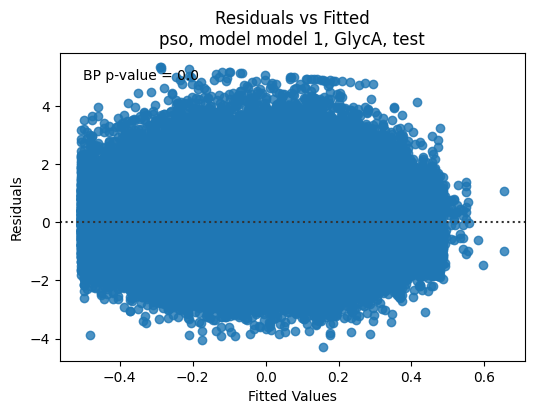

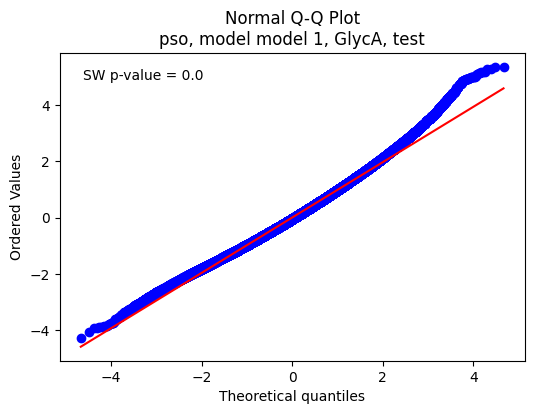

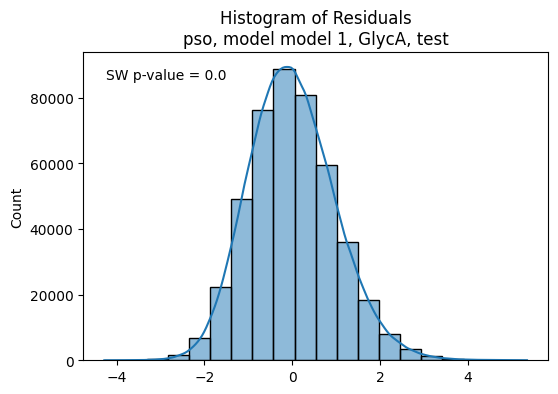

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

met_to_check = 'GlycA'

model = smf.ols(formula=f'{met_to_check}_cltrsc ~ age + sex + cent + pso', data=baseline_df, missing='drop')
result = model.fit()

# Check the result
print(result.summary())

# Run diagnostics on the model
model_diagnostics(result, 'pso', 'model 1', f'{met_to_check}', 'test')

The diagnostic result indicates heteroscedasticity, thus we need to correct the standard error and p-values using heteroscedasticity robust standard error.

In [ ]:
model_robust = model.fit(cov_type='HC0')

# Check the result
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:           GlycA_cltrsc   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     488.9
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:21:53   Log-Likelihood:            -6.3606e+05
No. Observations:              453428   AIC:                         1.272e+06
Df Residuals:                  453403   BIC:                         1.272e+06
Df Model:                          24                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5979      0.021    -

#### 3.1.2. Logistic regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

met_to_check = 'GlycA'

model = smf.glm(formula=f'pso ~ age + sex + cent + {met_to_check}_cltrsc', data=baseline_df, missing='drop', family = sm.families.Binomial())
result = model.fit()

# Check the result
print(result.summary())
print(f"Odds ratio: {np.exp(result.params['GlycA_cltrsc'])}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pso   No. Observations:               453428
Model:                            GLM   Df Residuals:                   453403
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48974.
Date:                Tue, 20 Jan 2026   Deviance:                       97947.
Time:                        14:21:58   Pearson chi2:                 4.53e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.002281
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.8925      0.221    -

### 3.2. Looping through all metabolites

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# Define the diseases
outcomes = ['pso', # Psoriasis
            # 'sev', 'non_sev', 'sev_non_sev', # Psoriasis severity
            'psa', 'non_psa', 'psa_non_psa', # Psoriatic arthritis
            'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

# Define the metabolites
mets_sc    = [met_name + '_sc' for met_name in met_names] # Scaled from the original
mets_clsc  = [met_name + '_clsc' for met_name in met_names] # Scaled no outlier
mets_cltrsc= [met_name + '_cltrsc' for met_name in met_names] # Scaled transformed no outlier
mets_uctrsc= [met_name + '_uctrsc' for met_name in met_names] # Scaled transformed (uncleaned)

met_types       = [mets_cltrsc] #options: mets_sc, mets_clsc, mets_cltrsc, mets_uctrsc
met_types_title = ['cleaned_transformed_scaled'] #options: 'scaled', 'cleaned_scaled', 'cleaned_transformed_scaled', 'uncleaned_transformed_scaled'

# Set regression type: 'linear' for OLS or 'logistic' for logistic regression
regression_type = 'linear'

# Loop over each outcome (disease) variable
for outcome in outcomes:

    for j, met_type in enumerate(met_types):

        # Build formula depending on regression type
        if regression_type.lower() == 'logistic':
            # In logistic regression, the outcome is the dependent variable and metabolite is a predictor.
            formula_templates = [
                f"{outcome} ~ {{met}}",
                f"{outcome} ~ {{met}} + age + sex + cent",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi + smo + meds"
            ]
        else:
            # In linear regression, the metabolite is the dependent variable.
            formula_templates = [
                "{met} ~ " + outcome, # model 0
                "{met} ~ age + sex + cent + " + outcome, # model 1
                "{met} ~ age + sex + cent + bmi + " + outcome, # model 2
                "{met} ~ age + sex + cent + bmi + smo + " + outcome, # model 3
                "{met} ~ age + sex + cent + bmi + smo + meds + " + outcome, # model 4
                "{met} ~ age + sex + cent + bmi + smo + meds + fish_tran + " + outcome, # model 5, for sensitivity analysis
                "{met} ~ age + sex + cent + bmi + smo + meds + veg_fru + " + outcome, # model 6, for sensitivity analysis
                "{met} ~ age + sex + cent + bmi + smo + meds + upf + " + outcome, # model 7, for sensitivity analysis
                "{met} ~ age + sex + cent + bmi + smo + meds + fish_tran + veg_fru + upf + red_meat +" + outcome, # model 8, for sensitivity analysis
                "{met} ~ age + sex + cent + bmi + smo + meds + red_meat + " + outcome, # model 9, for sensitivity analysis (put it here so model 5-8 match with HUNT)
            ]
        # Loop over each model type (formula)
        for i, formula_template in enumerate(formula_templates):
            print(f'Running {regression_type} regression for {outcome} - model {i} - {met_types_title[j]}')

            mets, coefs, lo_cis, up_cis, pvals, sample_sizes, note = [], [], [], [], [], [], []

            # Loop over each metabolite in the current metabolite type
            for k, met in enumerate(met_type):

                # Build the regression formula for the current metabolite
                formula = formula_template.format(met=met)

                # Fit the model while dropping rows with missing values
                if regression_type.lower() == 'logistic':
                    model = smf.glm(formula=formula, data=baseline_df, missing='drop', family = sm.families.Binomial())
                    result = model.fit()
                else:
                    model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                    result = model.fit()

                    # Perform BP test for detecting heteroscedasticity
                    bp_test = het_breuschpagan(result.resid, result.model.exog)
                    bp_p = round(bp_test[1], 4)

                    if bp_p < 0.05:
                        model = smf.ols(formula=formula, data=baseline_df, missing='drop')
                        result = model.fit(cov_type='HC0')
                        diagnostic = 'heteroscedastic'
                    else:
                        diagnostic = 'homoscedastic'

                # Extract the coefficient, confidence intervals, and p-value.
                # Note: Which parameter we extract depends on regression type.
                # For logistic regression, we extract the coefficient of the metabolite,
                # whereas for linear regression we extract the coefficient of the outcome.
                if regression_type.lower() == 'logistic':
                    # For logistic regression, our key predictor is the metabolite.
                    coef = np.exp(result.params[met])
                    conf_int = np.exp(result.conf_int().loc[met])
                    pvalue = result.pvalues[met]
                else:
                    # For linear regression, we extract the coefficient for the outcome.
                    coef = result.params[outcome]
                    conf_int = result.conf_int().loc[outcome]
                    pvalue = result.pvalues[outcome]

                nobs = result.nobs  # Number of observations used in the model

                # Append results to the lists
                mets.append(met)
                coefs.append(coef)
                lo_cis.append(conf_int[0])
                up_cis.append(conf_int[1])
                pvals.append(pvalue)
                sample_sizes.append(nobs)

                if regression_type.lower() == 'linear':
                    note.append(diagnostic)
                else:
                    pass

            # Build a summary dataframe
            if regression_type.lower() == 'linear':
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'beta': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes,  # Number of samples used for each regression
                    'note': note
                })
            else:
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'or': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes
                })

            # Remove the suffixes
            res_df['metabolite'] = res_df['metabolite'].str.replace(r'(_sc|_clsc|_cltrsc|_uctrsc)$', '', regex=True)

            # Perform FDR correction on the collected p-values using the Benjamini-Hochberg procedure
            print('Calculating FDR..')
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
            res_df['fdrpval'] = pvals_corrected
            res_df['fdrsig'] = reject

            # Sort data from the lowest to the highest p-value
            res_df = res_df.sort_values('pvalue', ascending=True)

            # Save the summary to an Excel file for this outcome, model type, and metabolite type
            print('Saving result..')
            filename = f'ukb[{regression_type}-{outcome}-model{i}-{met_types_title[j]}]summarystatistics.xlsx'
            res_df.to_excel(filename, index=False)

Running linear regression for pso - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 4 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 5 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 6 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 7 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - model 8 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for pso - m

##### Robust Linear Regression

3 Methods Theory:
https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/
example: https://github.com/erykml/nvidia_articles/blob/main/robust_regression.ipynb

HUBER Regressor:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

##### Model Diagnostics

Cook's distance: https://www.scikit-yb.org/en/latest/api/regressor/influence.html#:~:text=Cook's%20Distance%20is%20a%20measure%20of%20how%20influential%20an%20instance,outliers%20in%20standard%2C%20OLS%20regression.

## 4. Sub-group and sensitivity analysis for psoriasis

Here, we perform sub-group analyses to investigate the cause of differing LDL level between UKB and HUNT. Some potential causes include differences in: lipid-lowering medication use, obesity status, and consumption of fatty fish or fish oil (https://www.ahajournals.org/doi/10.1161/JAHA.123.029512).

In [ ]:
# Separate datasets for lipid-lowering medication use
meds_no = baseline_df[baseline_df['meds'] == 0]
meds_yes = baseline_df[baseline_df['meds'] == 1]

print(f'N not using lipid-lowering medication: {len(meds_no)}')
print(f'N on lipid-lowering medication: {len(meds_yes)}')

# Separate datasets for obesity
obs_no = baseline_df[baseline_df['bmi'] < 30]
obs_yes = baseline_df[baseline_df['bmi'] >= 30]

print(f'N not obese: {len(obs_no)}')
print(f'N obese: {len(obs_yes)}')

# Separate datasets for consumption of fatty fish or fish oil
oil_rare = baseline_df[baseline_df['fish_tran'] == 0]
oil_often = baseline_df[baseline_df['fish_tran'] == 1]

print(f'N rarely consume fatty fish or fish oil: {len(oil_rare)}')
print(f'N often consume fatty fish or fish oil: {len(oil_often)}')

N not using lipid-lowering medication: 375256
N on lipid-lowering medication: 78172
N not obese: 344204
N obese: 109224
N rarely consume fatty fish or fish oil: 149114
N often consume fatty fish or fish oil: 304314


We also create another dataframe excluding participants with any of the other IMIDs (creating IMIDs free cases and control)

In [ ]:
# Slice dataframe to exclude other IMIDs
other_imids = ['ra', 'spa', 'uc', 'cd', 'sle', 'ad']

# Create the slice
pso_clean = baseline_df[(baseline_df[other_imids] == 0).all(axis=1)]

In [ ]:
# Set outcome to psoriasis only
outcome = 'pso'

# Define the datasets
data_map = {
    'meds_no': meds_no,
    'meds_yes': meds_yes,
    'obs_no': obs_no,
    'obs_yes': obs_yes,
    'oil_rare': oil_rare,
    'oil_often': oil_often,
    'pso_clean': pso_clean # for sensitivity analysis
}

dfs = list(data_map.keys())

# Loop over each outcome (disease) variable
for df in dfs:

    for j, met_type in enumerate(met_types):

        # Build formula depending on regression type
        if regression_type.lower() == 'logistic':
            # In logistic regression, the outcome is the dependent variable and metabolite is a predictor.
            formula_templates = [
                f"{outcome} ~ {{met}}",
                f"{outcome} ~ {{met}} + age + sex + cent",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi",
                f"{outcome} ~ {{met}} + age + sex + cent + bmi + smo + meds"
            ]
        else:
            # In linear regression, the metabolite is the dependent variable.
            formula_templates = [
                "{met} ~ " + outcome, # model 0
                "{met} ~ age + sex + cent + " + outcome, # model 1
                "{met} ~ age + sex + cent + bmi + " + outcome, # model 2
                "{met} ~ age + sex + cent + bmi + smo + " + outcome, # model 3
                "{met} ~ age + sex + cent + bmi + smo + meds + " + outcome, # model 4
            ]
        # Loop over each model type (formula)
        for i, formula_template in enumerate(formula_templates):
            print(f'Running {regression_type} regression for {df} - model {i} - {met_types_title[j]}')

            mets, coefs, lo_cis, up_cis, pvals, sample_sizes, note = [], [], [], [], [], [], []

            # Loop over each metabolite in the current metabolite type
            for k, met in enumerate(met_type):

                # Build the regression formula for the current metabolite
                formula = formula_template.format(met=met)

                # Fit the model while dropping rows with missing values
                if regression_type.lower() == 'logistic':
                    model = smf.glm(formula=formula, data=data_map[df], missing='drop', family = sm.families.Binomial())
                    result = model.fit()
                else:
                    model = smf.ols(formula=formula, data=data_map[df], missing='drop')
                    result = model.fit()

                    # Perform BP test for detecting heteroscedasticity
                    bp_test = het_breuschpagan(result.resid, result.model.exog)
                    bp_p = round(bp_test[1], 4)

                    if bp_p < 0.05:
                        model = smf.ols(formula=formula, data=data_map[df], missing='drop')
                        result = model.fit(cov_type='HC0')
                        diagnostic = 'heteroscedastic'
                    else:
                        diagnostic = 'homoscedastic'

                # Extract the coefficient, confidence intervals, and p-value.
                # Note: Which parameter we extract depends on regression type.
                # For logistic regression, we extract the coefficient of the metabolite,
                # whereas for linear regression we extract the coefficient of the outcome.
                if regression_type.lower() == 'logistic':
                    # For logistic regression, our key predictor is the metabolite.
                    coef = np.exp(result.params[met])
                    conf_int = np.exp(result.conf_int().loc[met])
                    pvalue = result.pvalues[met]
                else:
                    # For linear regression, we extract the coefficient for the outcome.
                    coef = result.params[outcome]
                    conf_int = result.conf_int().loc[outcome]
                    pvalue = result.pvalues[outcome]

                nobs = result.nobs  # Number of observations used in the model

                # Append results to the lists
                mets.append(met)
                coefs.append(coef)
                lo_cis.append(conf_int[0])
                up_cis.append(conf_int[1])
                pvals.append(pvalue)
                sample_sizes.append(nobs)

                if regression_type.lower() == 'linear':
                    note.append(diagnostic)
                else:
                    pass

            # Build a summary dataframe
            if regression_type.lower() == 'linear':
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'beta': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes,  # Number of samples used for each regression
                    'note': note
                })
            else:
                res_df = pd.DataFrame({
                    'metabolite': mets,
                    'or': coefs,
                    'lower_ci': lo_cis,
                    'upper_ci': up_cis,
                    'pvalue': pvals,
                    'n': sample_sizes
                })

            # Remove the suffixes
            res_df['metabolite'] = res_df['metabolite'].str.replace(r'(_sc|_clsc|_cltrsc|_uctrsc)$', '', regex=True)

            # Perform FDR correction on the collected p-values using the Benjamini-Hochberg procedure
            print('Calculating FDR..')
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
            res_df['fdrpval'] = pvals_corrected
            res_df['fdrsig'] = reject

            # Sort data from the lowest to the highest p-value
            res_df = res_df.sort_values('pvalue', ascending=True)

            # Save the summary to an Excel file for this outcome, model type, and metabolite type
            print('Saving result..')
            filename = f'ukb[{regression_type}-{outcome}-{df}-model{i}-{met_types_title[j]}]summarystatistics.xlsx'
            res_df.to_excel(filename, index=False)

Running linear regression for meds_no - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_no - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_no - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_no - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_no - model 4 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_yes - model 0 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_yes - model 1 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_yes - model 2 - cleaned_transformed_scaled
Calculating FDR..
Saving result..
Running linear regression for meds_yes - model 3 - cleaned_transformed_scaled
Calculating FDR..
Saving result

## 5. Baseline table

### 5.1. Recode numerical values into categorical

In [ ]:
# Define function to convert codes based on a dictionary
def convcod(lst, dic):
    update = list((pd.Series(lst)).map(dic))
    return update

# Dictionary of smoking status codes
smo_codes = {0:'never', 1:'previous', 2:'current'}

# Dictionary of sex codes
sex_codes = {0:'female', 1:'male'}

# Dictionary of yes/no codes
oth_codes = {0:'no', 1:'yes'}

# Dictionary of diet codes
diet_codes = {0:'rare', 1:'often'}

baseline_df['sex'] = convcod(baseline_df['sex'], sex_codes)
baseline_df['smo'] = convcod(baseline_df['smo'], smo_codes)
baseline_df['meds'] = convcod(baseline_df['meds'], oth_codes)
baseline_df['pso'] = convcod(baseline_df['pso'], oth_codes)
baseline_df['sev_non_sev'] = convcod(baseline_df['sev_non_sev'], oth_codes)
baseline_df['psa_non_psa'] = convcod(baseline_df['psa_non_psa'], oth_codes)
baseline_df['ad'] = convcod(baseline_df['ad'], oth_codes)
baseline_df['ra'] = convcod(baseline_df['ra'], oth_codes)
baseline_df['sle'] = convcod(baseline_df['sle'], oth_codes)
baseline_df['uc'] = convcod(baseline_df['uc'], oth_codes)
baseline_df['cd'] = convcod(baseline_df['cd'], oth_codes)
baseline_df['spa'] = convcod(baseline_df['spa'], oth_codes)
baseline_df['fish_tran'] = convcod(baseline_df['fish_tran'], diet_codes)
baseline_df['red_meat'] = convcod(baseline_df['red_meat'], diet_codes)
baseline_df['veg_fru'] = convcod(baseline_df['veg_fru'], diet_codes)
baseline_df['upf'] = convcod(baseline_df['upf'], diet_codes)

### 5.2. Characteristics table

In [ ]:
!pip install tableone

In [ ]:
from tableone import TableOne

cat_vars = ['sex', 'smo', 'meds', 'fish_tran', 'red_meat', 'veg_fru', 'upf']
cont_vars = ['fast', 'bmi', 'age']

outcomes = ['pso',
            'sev_non_sev', # Psoriasis severity
            'psa_non_psa', # Psoriatic arthritis
            'ra', 'spa', 'uc', 'cd', 'sle', 'ad' #IMIDs
           ]

for k, outcome in enumerate(outcomes):
    baseline_table = TableOne(data=baseline_df[cat_vars + cont_vars + outcomes],
                              categorical = cat_vars + outcomes,
                              nonnormal = cont_vars,
                              normal_test = True, # scipy.stats.normaltest based on D'Agostino and Pearson
                              pval=True,
                              groupby = outcome,
                              missing = False
                             )

    baseline_table.to_excel(f'ukb_{outcome}_characteristics_table.xlsx')

baseline_table

Grouped by ad                                            
                                        Overall                no               yes P-Value
n                                        453428            444210              9218        
sex, n (%)           female       246321 (54.3)     240945 (54.2)       5376 (58.3)  <0.001
                     male         207107 (45.7)     203265 (45.8)       3842 (41.7)        
smo, n (%)           current       47172 (10.4)      46262 (10.4)         910 (9.9)   0.016
                     never        244324 (53.9)     239430 (53.9)       4894 (53.1)        
                     previous     161932 (35.7)     158518 (35.7)       3414 (37.0)        
meds, n (%)          no           375256 (82.8)     367618 (82.8)       7638 (82.9)   0.808
                     yes           78172 (17.2)      76592 (17.2)       1580 (17.1)        
fish_tran, n (%)     often        304314 (67.1)     298092 (67.1)       6222 (67.5)   0.434
                     rare         149114 (32.9)     146118 (32.9)       2996 (32.5)        
red_meat, n (%)      often        252544 (55.7)     247495 (55.7)       5049 (54.8)   0.073
                     rare         200884 (44.3)     196715 (44.3)       4169 (45.2)        
veg_fru, n (%)       often        448147 (98.8)     439047 (98.8)       9100 (98.7)   0.320
                     rare            5281 (1.2)        5163 (1.2)         118 (1.3)        
upf, n (%)           often        277573 (61.2)     272074 (61.2)       5499 (59.7)   0.002
                     rare         175855 (38.8)     172136 (38.8)       3719 (40.3)        
fast, median [Q1,Q3]              3.0 [2.0,4.0]     3.0 [2.0,4.0]     3.0 [2.0,4.0]   0.013
bmi, median [Q1,Q3]            26.7 [24.1,29.8]  26.7 [24.1,29.8]  26.8 [24.1,30.0]   0.205
age, median [Q1,Q3]            58.0 [50.0,63.0]  58.0 [50.0,63.0]  58.0 [50.0,63.0]   0.322
pso, n (%)           no           443041 (97.7)     434296 (97.8)       8745 (94.9)  <0.001
                     yes            10387 (2.3)        9914 (2.2)         473 (5.1)        
sev_non_sev, n (%)   None         443041 (97.7)     434296 (97.8)       8745 (94.9)  <0.001
                     no              9696 (2.1)        9243 (2.1)         453 (4.9)        
                     yes              691 (0.2)         671 (0.2)          20 (0.2)        
psa_non_psa, n (%)   None         443041 (97.7)     434296 (97.8)       8745 (94.9)  <0.001
                     no             10027 (2.2)        9562 (2.2)         465 (5.0)        
                     yes              360 (0.1)         352 (0.1)           8 (0.1)        
ra, n (%)            no           447397 (98.7)     438319 (98.7)       9078 (98.5)   0.121
                     yes             6031 (1.3)        5891 (1.3)         140 (1.5)        
spa, n (%)           no           451992 (99.7)     442805 (99.7)       9187 (99.7)   0.807
                     yes             1436 (0.3)        1405 (0.3)          31 (0.3)        
uc, n (%)            no           449614 (99.2)     440504 (99.2)       9110 (98.8)  <0.001
                     yes             3814 (0.8)        3706 (0.8)         108 (1.2)        
cd, n (%)            no           451533 (99.6)     442358 (99.6)       9175 (99.5)   0.517
                     yes             1895 (0.4)        1852 (0.4)          43 (0.5)        
sle, n (%)           no           452811 (99.9)     443607 (99.9)       9204 (99.8)   0.785
                     yes              617 (0.1)         603 (0.1)          14 (0.2)        
ad, n (%)            no           444210 (98.0)    444210 (100.0)           0 (0.0)  <0.001
                     yes             9218 (2.0)           0 (0.0)      9218 (100.0)        
[1] Normality test reports non-normal
                                    distributions for: age, bmi, fast.

TableOne documentation: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://readthedocs.org/projects/tableone/downloads/pdf/latest/
Example: https://github.com/tompollard/tableone/blob/main/tableone.ipynb

In [ ]:
%%bash
dx upload *.xlsx

ID                                file-J5jGX40JZ8jV1J2ff2pPBJXX
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              ukb[linear-ad-model0-cleaned_transformed_scaled]summarystatistics.
                                  xlsx
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Wed Jan 21 12:39:44 2026
Created by                        agarham
 via the job                      job-J5gjb80JZ8jz9PqxZFB1jFyV
Last modified                     Wed Jan 21 12:39:45 2026
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J5jGX48JZ8jV1J2ff2pPBJXb
Class